# EDS tomography pipeline overview

For any questions, e-mail Zack Gainsforth (zackg@berkeley.edu).

We start with a sequence of EDS acquisitions.  We have one Bruker file (angle.bcf) for each stage tilt.  angle = whatever the stage alpha is in degrees.  These files are all in an input directory.  The processing sequence is:

1. Pull the raw signals out of the bcf files.  Each signal could be an element or could be an energy window.
2. Normalize the signals as a function of stage tilt (there is variable shadowing of the detector at different tilts.)
3. Output the signals to tiff stacks.
4. Use an external program (TomViz or ImageJ) to align one of the tif stacks and save the alignments to a text file.
5. Apply that alignment across all the signals.
6. Output everything into a format that GENFIRE can read, and setup GENFIRE calculations.
7. Do the GENFIRE calculations (generally on a compute cluster).
8. Read in the results and trim the cubes (there is usually some noise at the periphery).
9. Produce visualizations in ChimeraX.

Let's go!

In [22]:
import sys, os, shutil
import numpy as np
import matplotlib.pyplot as plt
import genfire
import ipyvolume
import os

# It annoys me that I have a large screen and these notebooks are a tiny -- narrow -- itsy bitsy column down the middle.
# The following two lines make jupyter notebook use the whole window!  Comment them out if you don't like it.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# I also like images to be bigger than default.
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session

# I'm on a mac so I get to use retina resolution on my images.  Uncomment this line if you're using a mac too.
%config InlineBackend.figure_format = 'retina'

In [26]:
# These are the directories for the different stages of processing.
InputDirectory = os.path.join('Input')
OutputDirectory = os.path.join('Output4bin', 'Unaligned')
AlignedDirectory = os.path.join('Output4bin', 'Aligned')
ReconstructedDirectory = os.path.join('Output4bin', 'Reconstructed')

# These are the signals we will extract today.
SignalNames = ['HAADF', 'Al_Ka', 'C_Ka', 'Ca_Ka', 'Cr_Ka', 'Fe_Ka', 'Ga_Ka', 'Mg_Ka', 'Na_Ka', 'Ni_Ka', 'O_Ka', 'P_Ka', 'Pt_La', 'S_Ka', 'Si_Ka']


In [24]:
from ncempy.edstomo import preprocess, postprocess
# If you get a warning about traitsui, ignore it.  We're not using traitsui.

# 1. Pull the raw signals out of bcf files.
You have to have all the bcf files in one directory and named like this:

-10.bcf  
-5.bcf  
0.bcf  
5.bcf  
10.bcf  
etc.

The code will automatically construct a list of tilts from the names of the files and sort them according to tilts.

In [25]:
# First we extract the raw signals from the bcf files.  We infer the list of stage tilts from the names of the files.
# The EDS channels will be two binned (meaning each voxel is 2x2x2 voxels summed).  The HAADF channel is unchanged.
Signals, Tilts = preprocess.ExtractRawSignalsFromBrukerSequence(InputDirectory=InputDirectory, SignalNames=SignalNames, Binning=4)
print(f'Signal Names: {Signals.keys()}')
print(f'HAADF signal shape: {Signals["HAADF"].shape}')
print(f'Fe_Ka signal shape: {Signals["Fe_Ka"].shape}')
print(f'Tilts: {Tilts}')
print('At this point all this data is held in RAM.  Hopefully you have enough!')

Extracting Signals from:
Binning is 4 so rebinned cubes will have spatial dimension (64, 64).
Input/-50.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-45.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-40.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-35.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-30.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-25.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-20.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_Ka, Ga_Ka, Mg_Ka, Na_Ka, Ni_Ka, O_Ka, P_Ka, Pt_La, S_Ka, Si_Ka, done.
Input/-15.bcf: HAADF, Al_Ka, C_Ka, Ca_Ka, Cr_Ka, Fe_

# 2. Tilt Normalization

As the stage tilts, more/different material enters the field of view, and the EDS detectors are shadowed differently. This causes the intensity of the EDS signals to vary as a function of stage tilt.  On our microscope, the minimum signal occurs at +/- 18 degrees because the takeoff angle of our 4 EDS detectors is 18 deg. We select a small portion out of the middle, (in this case a box half the width and height of the FOV) and sum that up to determine the normalization intensity.  We do this only for the Si_Ka signal since it is a good tradeoff between a high enough energy such that attenuation of the signal within the sample is small, and still has good signal.  The choice of which channel to use is dependent on your sample. We then apply that normalization across all the EDS signals.

In [27]:
Signals, NormCurve = preprocess.NormalizeSignals(Signals, Tilts, NormalizationSignalName='Si_Ka', NormalizationImageFraction=0.5)

Producing normalization curve for all signals based on Si_Ka.


Text(0, 0.5, 'Normalization multiplier')

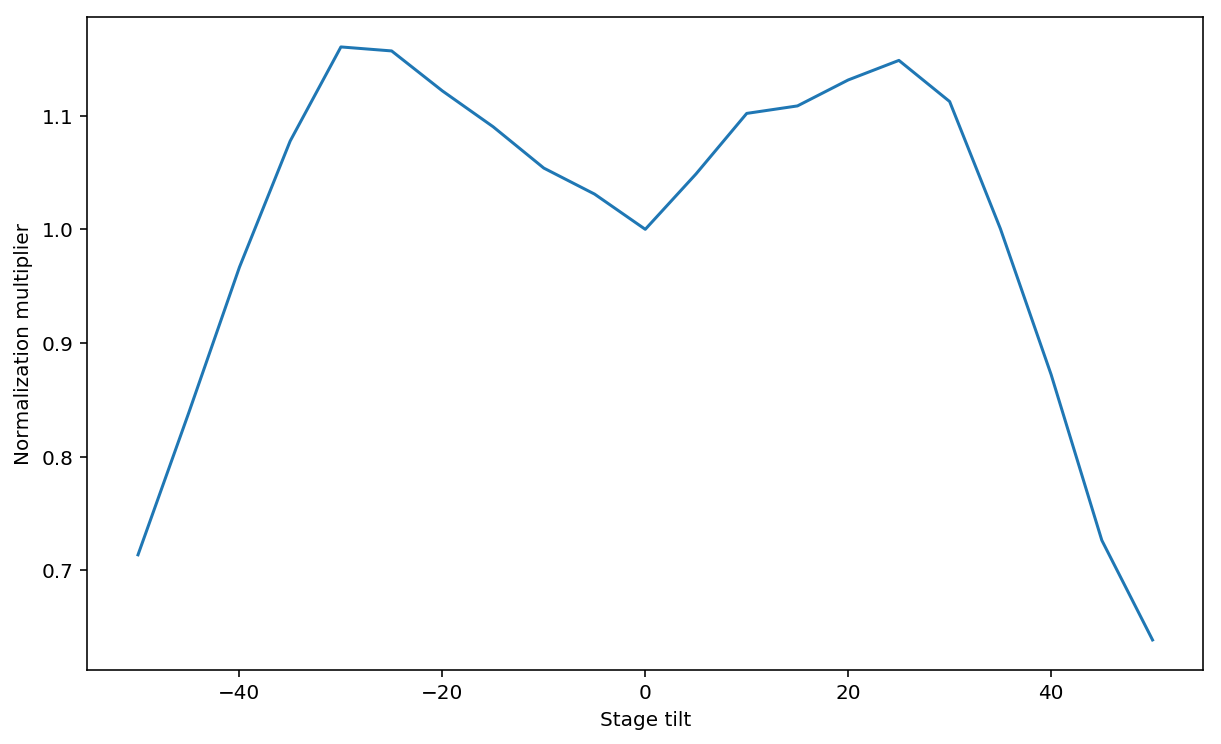

In [28]:
plt.plot(Tilts,NormCurve)
plt.xlabel('Stage tilt')
plt.ylabel('Normalization multiplier')

# 3. Output data to tifs for alignment.

In [29]:
preprocess.WriteSignalsToTIFFs(OutputDirectory, Signals)
preprocess.WriteMetaDataFiles(OutputDirectory, Tilts, NormCurve, NormalizationSignalName='Si_Ka')

Creating directory: Output4bin/Unaligned
Writing HAADF.tif
Writing Al_Ka.tif
Writing C_Ka.tif
Writing Ca_Ka.tif
Writing Cr_Ka.tif
Writing Fe_Ka.tif
Writing Ga_Ka.tif
Writing Mg_Ka.tif
Writing Na_Ka.tif
Writing Ni_Ka.tif
Writing O_Ka.tif
Writing P_Ka.tif
Writing Pt_La.tif
Writing S_Ka.tif
Writing Si_Ka.tif
Writing tilts file.


# 4. Align stack using TomViz or ImageJ.  In this case we will use TomViz.

For alignment we used TomViz and manually aligned the HAADF signal.

This is what our alignment looked like:

<img src='TomVizAlign.png' width=50%>

<font size=4 color='red'>Don't forget to save the alignment file as 'TomVizAlignments.json'!!!</font>


# 5. Apply alignment to all signals.

Notice that the HAADF signal is a different size than the EDS signals because it was not binned.  This is because the HAADF signal usually has high SNR so it is possible to do a full tomographic reconstruction on it without binning.  However, the image translations for the individual images in the HAADF tilt series will have to be scaled down for each of the EDS channels.  Therefore it is important to tell the alignment function which channel was used to align.  It will automatically scale everything accordingly.  Sorry, as of now, only pixel alignment -- no subpixel scaling!

In [30]:
Translations = preprocess.ReadTomVizTranslations(os.path.join(OutputDirectory, 'TomVizAlignments.json'), Tilts)
AlignedSignals = preprocess.ApplyTranslations(Signals, Translations, 'HAADF')

Aligning HAADF
TranslationScale: [1. 1.]
Aligning Al_Ka
TranslationScale: [0.25 0.25]
Aligning C_Ka
TranslationScale: [0.25 0.25]
Aligning Ca_Ka
TranslationScale: [0.25 0.25]
Aligning Cr_Ka
TranslationScale: [0.25 0.25]
Aligning Fe_Ka
TranslationScale: [0.25 0.25]
Aligning Ga_Ka
TranslationScale: [0.25 0.25]
Aligning Mg_Ka
TranslationScale: [0.25 0.25]
Aligning Na_Ka
TranslationScale: [0.25 0.25]
Aligning Ni_Ka
TranslationScale: [0.25 0.25]
Aligning O_Ka
TranslationScale: [0.25 0.25]
Aligning P_Ka
TranslationScale: [0.25 0.25]
Aligning Pt_La
TranslationScale: [0.25 0.25]
Aligning S_Ka
TranslationScale: [0.25 0.25]
Aligning Si_Ka
TranslationScale: [0.25 0.25]


# 6. Output everything into a format that GENFIRE can read, and setup GENFIRE calculations.

We create a file DoGenfire.py in the output directory which can be used to run GENFIRE neatly from the command line. GENFIRE requires a .npy file which contains the tilt sequence. We also make a shell script which runs GENFIRE in a compute cluster environment.  Similarly, we produce runall.sh which runs all the stacks using slurm (a common process manager on supercomputers -- and one we use on our cluster.  This can take a lot of compute time if you run it on a single machine.

In [31]:
preprocess.WriteSignalsToTIFFs(AlignedDirectory, AlignedSignals)
preprocess.WriteMetaDataFiles(AlignedDirectory, Tilts, NormCurve, NormalizationSignalName='Si_Ka')
preprocess.WriteSignalsToGENFIRE(AlignedDirectory, AlignedSignals, Tilts)

Creating directory: Output4bin/Aligned
Writing HAADF.tif
Writing Al_Ka.tif
Writing C_Ka.tif
Writing Ca_Ka.tif
Writing Cr_Ka.tif
Writing Fe_Ka.tif
Writing Ga_Ka.tif
Writing Mg_Ka.tif
Writing Na_Ka.tif
Writing Ni_Ka.tif
Writing O_Ka.tif
Writing P_Ka.tif
Writing Pt_La.tif
Writing S_Ka.tif
Writing Si_Ka.tif
Writing tilts file.
Writing HAADF_aligned.npy, Writing HAADF_slurm.sh
Writing Al_Ka_aligned.npy, Writing Al_Ka_slurm.sh
Writing C_Ka_aligned.npy, Writing C_Ka_slurm.sh
Writing Ca_Ka_aligned.npy, Writing Ca_Ka_slurm.sh
Writing Cr_Ka_aligned.npy, Writing Cr_Ka_slurm.sh
Writing Fe_Ka_aligned.npy, Writing Fe_Ka_slurm.sh
Writing Ga_Ka_aligned.npy, Writing Ga_Ka_slurm.sh
Writing Mg_Ka_aligned.npy, Writing Mg_Ka_slurm.sh
Writing Na_Ka_aligned.npy, Writing Na_Ka_slurm.sh
Writing Ni_Ka_aligned.npy, Writing Ni_Ka_slurm.sh
Writing O_Ka_aligned.npy, Writing O_Ka_slurm.sh
Writing P_Ka_aligned.npy, Writing P_Ka_slurm.sh
Writing Pt_La_aligned.npy, Writing Pt_La_slurm.sh
Writing S_Ka_aligned.npy, Writi

# 7. Do the GENFIRE calculations (generally on a compute cluster).

In our case we take the output directory, upload it to the cluster using Globus, log into the cluster and execute:

```
chmod +x runall.sh
./runall.sh
```

We wind up with something like this:

<img src='SlurmOutput.png' width=50%>

# 8. Read in the results and trim the cubes.

In [32]:
# Choose one to view and figure out what the truncation bounds should be.
Signal = genfire.fileio.readMRC(os.path.join(ReconstructedDirectory, 'Mg_Ka_reconstruction.mrc'))

CropBounds = {'xmin': 0.40, 'xmax': 0.60,
              'ymin': 0.10, 'ymax': 0.90,
              'zmin': 0.15, 'zmax': 0.85}

Signal = postprocess.SquareCropSignal(Signal, CropBounds)
print(Signal.shape)
ipyvolume.quickvolshow(Signal)

(64, 64, 64)


In [33]:
# Apply that cropping to all stacks.
# Now loop through all the maps and clip them all.
for Signal in Signals:
    print(f'Cropping {Signal}.')
    Cube = genfire.fileio.readMRC(os.path.join(ReconstructedDirectory, Signal+'_reconstruction.mrc'))
    Cube = postprocess.SquareCropSignal(Cube, CropBounds)
    genfire.fileio.writeMRC(arr=Cube, filename=os.path.join(ReconstructedDirectory, Signal+'_reconstruction_cropped.mrc'))
print('Done.')

Cropping HAADF.
Cropping Al_Ka.
Cropping C_Ka.
Cropping Ca_Ka.
Cropping Cr_Ka.
Cropping Fe_Ka.
Cropping Ga_Ka.
Cropping Mg_Ka.
Cropping Na_Ka.
Cropping Ni_Ka.
Cropping O_Ka.
Cropping P_Ka.
Cropping Pt_La.
Cropping S_Ka.
Cropping Si_Ka.
Done.


# 9. Produce visualizations in ChimeraX.
At this point the reconstruction is done.  You can simply open up "signal_reconstruction_cropped.mrc" in any visualizer you like.  We use ChimeraX.  It provides the ability to script the display, can display multiple channels easily at once, and also allows for VR viewing.
ChimeraX has its own documentation and we don't reproduce it here.  However, let's go through a simple example just to get started.
There is a ManyElements2bin.cxc (and 4bin) in the data directory.  Opening them up in ChimeraX looks like this:

<table>
    <tr>
        <td align="center"><font size=4>ManyElements2bin.cxc</font></td><td align="center"><font size=4>ManyElements4bin.cxc</font></td>
    </tr>
    <tr>
        <td><img src='ManyElements2bin.png'></td><td><img src='ManyElements4bin.png'></td>
    </tr>
</table>

By comparison, these are EDS maps taken without any stage tilt, and for a longer acquisition:

<img src='Mosaic.png' width=75%>

Compare the two views and adjust thresholds for surfaces in ChimeraX until it matches the actual phase boundaries.  In our humble opinion, the 4-binned version is superior in this case so we default to 4 binning in this demo.

In [34]:
!jupyter-nbconvert --to html 'Process_L2083-K-4-1.ipynb'

[NbConvertApp] Converting notebook Process_L2083-K-4-1.ipynb to html
[NbConvertApp] Writing 347460 bytes to Process_L2083-K-4-1.html
